In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/prediction-of-factory-electric-consumption/submission.csv
/kaggle/input/prediction-of-factory-electric-consumption/train_df.csv
/kaggle/input/prediction-of-factory-electric-consumption/test_df.csv


In [11]:
!pip install gpytorch

In [12]:
df = pd.read_csv('/kaggle/input/prediction-of-factory-electric-consumption/train_df.csv')
df.head()

,Date,Electric_Consumption,Factor_A,Factor_B,Factor_C,Factor_D,Factor_E,Factor_F
0,2023-01-01T00:00:00.000,0.000000,1.242130,28.419739,13.720397,79.840600,0.0,2.386157
1,2023-01-01T01:00:00.000,0.000000,1.861285,29.840759,12.537668,86.424903,0.0,1.473256
2,2023-01-01T02:00:00.000,0.000000,4.212674,32.778036,9.408667,72.082793,0.0,1.583711
3,2023-01-01T03:00:00.000,0.000000,4.025251,32.624700,9.035601,73.825705,0.0,1.706656
4,2023-01-01T04:00:00.000,-0.000267,3.122659,31.931245,9.235502,66.823956,0.0,0.987048


In [14]:
import torch
import gpytorch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from datetime import datetime

class VariationalGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        # Define the variational distribution
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(0)
        )
        
        # Define the variational strategy
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution,
            learn_inducing_locations=True
        )
        
        super(VariationalGPModel, self).__init__(variational_strategy)
        
        # Mean and covariance modules
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=inducing_points.size(1))
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def prepare_data(data):
    # Convert date to numerical features
    data['Date'] = pd.to_datetime(data['Date'])
    data['hour'] = data['Date'].dt.hour
    data['day'] = data['Date'].dt.day
    data['month'] = data['Date'].dt.month
    
    # Prepare feature matrix X
    feature_cols = ['Factor_A', 'Factor_B', 'Factor_C', 'Factor_D', 
                   'Factor_E', 'Factor_F', 'hour', 'day', 'month']
    X = data[feature_cols].values
    y = data['Electric_Consumption'].values
    
    # Scale features
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()
    
    return (torch.FloatTensor(X_scaled), 
            torch.FloatTensor(y_scaled), 
            scaler_X, 
            scaler_y)

def select_inducing_points(X_train, num_inducing=100):
    """Select inducing points using kmeans clustering"""
    from sklearn.cluster import KMeans
    
    if len(X_train) <= num_inducing:
        return X_train
    
    kmeans = KMeans(n_clusters=num_inducing, random_state=42)
    kmeans.fit(X_train)
    inducing_points = torch.FloatTensor(kmeans.cluster_centers_)
    
    return inducing_points

def train_model(X_train, y_train, num_inducing=100, training_iterations=100, batch_size=1024):
    # Select inducing points
    inducing_points = select_inducing_points(X_train, num_inducing)
    
    # Initialize model and likelihood
    model = VariationalGPModel(inducing_points)
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    
    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},
        {'params': likelihood.parameters()},
    ], lr=0.01)

    # Our loss object. We're using the VariationalELBO
    mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y_train.size(0))
    
    # Create DataLoader for mini-batching
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    model.train()
    likelihood.train()
    
    for i in range(training_iterations):
        epoch_loss = 0
        for x_batch, y_batch in loader:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
        if (i + 1) % 10 == 0:
            print(f'Iteration {i+1}/{training_iterations} - Loss: {epoch_loss:.3f}')
    
    return model, likelihood

def make_predictions(model, likelihood, X_test, batch_size=1024):
    model.eval()
    likelihood.eval()
    
    # Initialize predictions
    means = []
    lower = []
    upper = []
    
    # Make predictions in batches
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        for i in range(0, len(X_test), batch_size):
            x_batch = X_test[i:i+batch_size]
            # Get output from model
            output = likelihood(model(x_batch))
            # Get mean and confidence region for batch
            means.append(output.mean)
            lower_batch, upper_batch = output.confidence_region()
            lower.append(lower_batch)
            upper.append(upper_batch)
    
    # Concatenate results
    mean_pred = torch.cat(means).numpy()
    lower_pred = torch.cat(lower).numpy()
    upper_pred = torch.cat(upper).numpy()
    
    return mean_pred, (lower_pred, upper_pred)

# Assuming 'data' is your DataFrame
X_train, y_train, scaler_X, scaler_y = prepare_data(df)

# Train the model
model, likelihood = train_model(X_train, y_train)

# Make predictions
mean_pred, (lower, upper) = make_predictions(model, likelihood, X_train)

# Transform predictions back to original scale
mean_pred = scaler_y.inverse_transform(mean_pred.reshape(-1, 1))
lower = scaler_y.inverse_transform(lower.reshape(-1, 1))
upper = scaler_y.inverse_transform(upper.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 10/100 - Loss: 11.957
Iteration 20/100 - Loss: 5.787
Iteration 30/100 - Loss: 3.595
Iteration 40/100 - Loss: 2.813
Iteration 50/100 - Loss: 2.598
Iteration 60/100 - Loss: 2.305
Iteration 70/100 - Loss: 2.084
Iteration 80/100 - Loss: 2.046
Iteration 90/100 - Loss: 1.925
Iteration 100/100 - Loss: 1.851


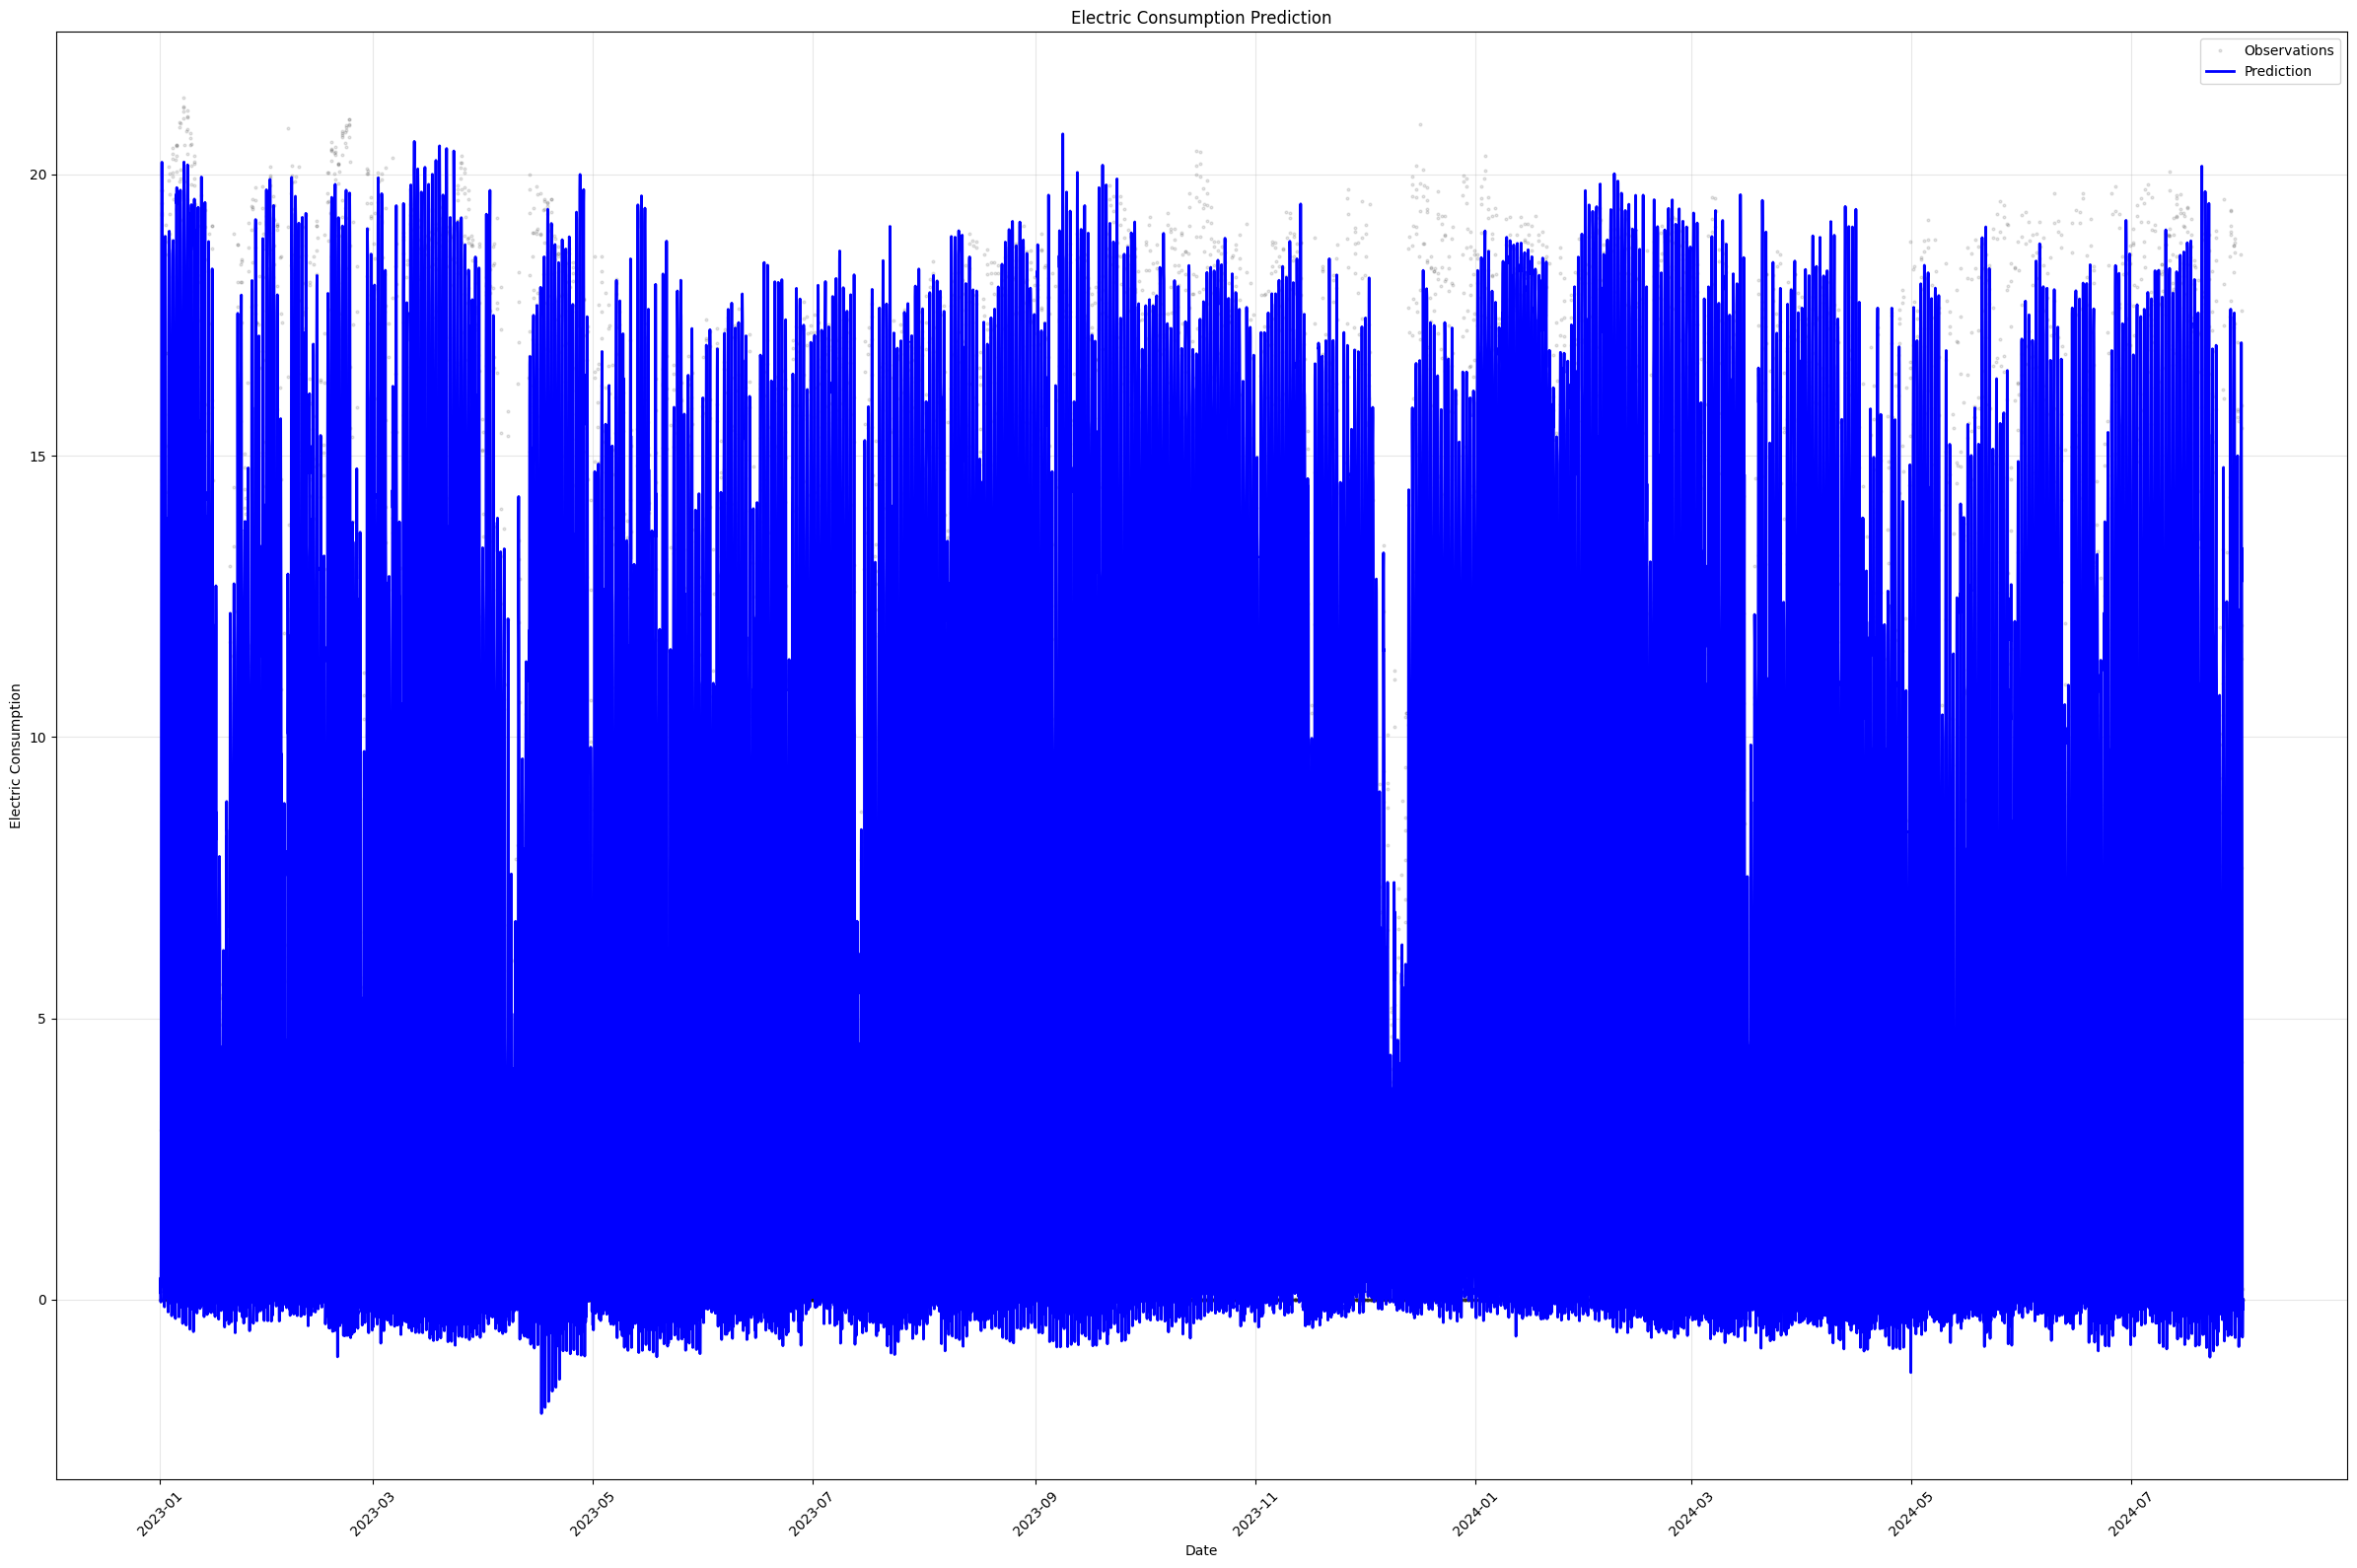

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming mean_pred, lower_bound, and upper_bound are already scaled back to original values
dates = pd.to_datetime(df['Date'])  # Convert to datetime if not already
y_true = df['Electric_Consumption'].values  # Original target values

plt.figure(figsize=(24, 16))

# Plot actual values
plt.plot(dates, y_true, 'k.', label='Observations', alpha=0.1, markersize=4)

# Plot predictions
plt.plot(dates, mean_pred, 'b-', label='Prediction', linewidth=2)

# Plot confidence bounds
# plt.fill_between(dates, lower_bound.flatten(), upper_bound.flatten(), 
                # alpha=0.2, label='95% Confidence', color='blue')

plt.title('Electric Consumption Prediction')
plt.xlabel('Date')
plt.ylabel('Electric Consumption')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()